In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_QoiMO9B.csv')
center = pd.read_csv('fulfilment_center_info.csv')
meal = pd.read_csv('meal_info.csv')

In [3]:
def data_description(df):
    for i in df.columns:
        print(i," : ", df[i].nunique())
    print("------------------------------------------")
    print("Shape is: ",df.shape)
    print("------------------------------------------")
    df.info()
    print("------------------------------------------")
    print("First 3 entries \n",df.head(3))

In [5]:
data_description(train)

In [4]:
center = pd.get_dummies(center)
center.head()

,center_id,city_code,region_code,op_area,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,11,679,56,3.7,1,0,0
1,13,590,56,6.7,0,1,0
2,124,590,56,4.0,0,0,1
3,66,648,34,4.1,1,0,0
4,94,632,34,3.6,0,0,1


In [5]:
meal = pd.get_dummies(meal)
meal.head()

,meal_id,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1885,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1993,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2539,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1248,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2631,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [6]:
train=pd.merge(train,center,how='left',on=['center_id'])
test=pd.merge(test,center,how='left',on=['center_id'])
train=pd.merge(train,meal,how='left',on=['meal_id'])
test=pd.merge(test,meal,how='left',on=['meal_id'])
test['num_orders'] = 0
train.shape,test.shape

((456548, 33), (32573, 33))

In [7]:
train.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,0,0,0,0,0,0,0,0,0,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,...,0,0,0,0,0,0,0,0,0,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,...,0,0,0,0,0,0,0,0,0,1


In [8]:
train_subset = train[0: 423974]
val_set = train[423975:]

In [10]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 150, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(3, 10, num = 5)]


min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 6, 8, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [11]:

rf = RandomForestRegressor()

imp_features = ['op_area','homepage_featured','emailer_for_promotion', 
                'base_price','category_Rice Bowl','checkout_price']
train_labels=train.num_orders
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train[imp_features], train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 83.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [12]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [14]:
x_test = test[imp_features]

pred_rf = rf_random.predict(x_test)

In [15]:
print(mean_squared_log_error(val_set.num_orders,pred_rf))

2.0981973080222507


In [2]:
y = train_subset.num_orders #Dependent Variable

features = ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'op_area', 'center_type_TYPE_A', 'center_type_TYPE_B',
       'center_type_TYPE_C', 'category_Beverages', 'category_Biryani',
       'category_Desert', 'category_Extras', 'category_Fish',
       'category_Other Snacks', 'category_Pasta', 'category_Pizza',
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian',
       'cuisine_Thai']
x = train_subset[features]
rf = RandomForestRegressor(n_estimators=150,min_samples_split=10,min_samples_leaf=2,max_features= 'sqrt' ,max_depth=10,bootstrap=True,n_jobs=-1,verbose=1)
rf.fit(x,y)

NameError: name 'train_subset' is not defined

In [31]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: homepage_featured    Importance: 0.2
Variable: checkout_price       Importance: 0.17
Variable: emailer_for_promotion Importance: 0.16
Variable: category_Rice Bowl   Importance: 0.12
Variable: base_price           Importance: 0.09
Variable: op_area              Importance: 0.05
Variable: category_Sandwich    Importance: 0.05
Variable: cuisine_Continental  Importance: 0.03
Variable: center_id            Importance: 0.02
Variable: meal_id              Importance: 0.02
Variable: category_Pasta       Importance: 0.02
Variable: cuisine_Italian      Importance: 0.02
Variable: category_Beverages   Importance: 0.01
Variable: category_Biryani     Importance: 0.01
Variable: category_Desert      Importance: 0.01
Variable: cuisine_Indian       Importance: 0.01
Variable: id                   Importance: 0.0
Variable: week                 Importance: 0.0
Variable: city_code            Importance: 0.0
Variable: region_code          Importance: 0.0
Variable: center_type_TYPE_A   Importance: 0

In [32]:
x_test = test[features]

pred_rf = rf.predict(x_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


In [33]:
print(mean_squared_log_error(val_set.num_orders,pred_rf))

1.86530200041906


In [36]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(val_set.num_orders,pred_rf)))

301.98175820330374


In [37]:
print(rf.score(x,y))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


0.3320666540706294


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.9s finished


In [38]:
import sklearn
sklearn.metrics.explained_variance_score(val_set.num_orders,pred_rf)

-0.19220597077996748

In [39]:
imp_features = ['op_area','homepage_featured','emailer_for_promotion', 
                'base_price','category_Rice Bowl','checkout_price']


x = train_subset[imp_features]

rf = RandomForestRegressor(n_estimators=150,min_samples_split=10,min_samples_leaf=2,max_features= 'sqrt' ,max_depth=3,bootstrap=True,n_jobs=-1,verbose=1)

rf.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

In [40]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(imp_features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: checkout_price       Importance: 0.23
Variable: homepage_featured    Importance: 0.22
Variable: category_Rice Bowl   Importance: 0.19
Variable: emailer_for_promotion Importance: 0.18
Variable: base_price           Importance: 0.13
Variable: op_area              Importance: 0.04


In [41]:
x_test = test[imp_features]

pred_rf = rf.predict(x_test)

print(mean_squared_log_error(val_set.num_orders,pred_rf))

1.8878468183949786


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


In [27]:
import sklearn
sklearn.metrics.explained_variance_score(val_set.num_orders,pred_rf)

-1.0950983281128015

In [28]:
sklearn.metrics.mean_absolute_error(val_set.num_orders,pred_rf)

243.32142018458399

In [29]:
sklearn.metrics.r2_score(val_set.num_orders,pred_rf)

-1.1075069947853562

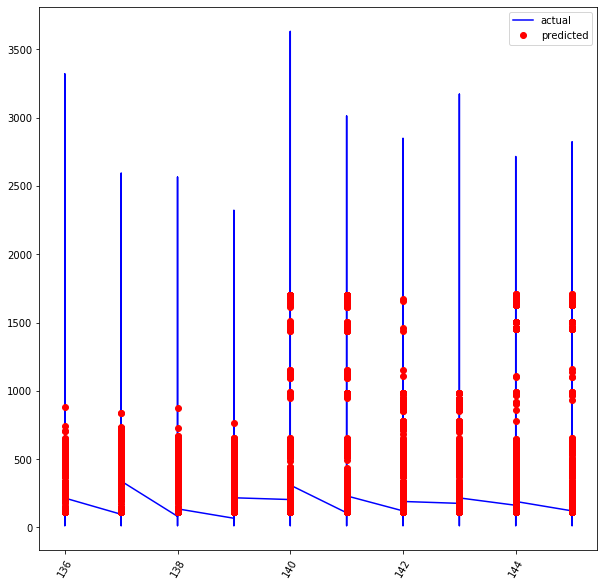

In [43]:
plt.figure(figsize = (10,10))
plt.plot(val_set.week,val_set.num_orders,'b-',label='actual')
plt.plot(val_set.week,pred_rf,'ro',label='predicted')
plt.xticks(rotation = '60'); 
plt.legend()

In [139]:
#val_set.num_orders.count()

In [140]:
#pred_rf.shape